### This is the code for generating Gravitational Waves (GW) using pycbc library

In [21]:
#please install the pycbc python library first
#reference: https://pycbc.org/pycbc/latest/html/install.html


#!pip install pycbc

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc.waveform import get_td_waveform
from tqdm import tqdm
import os


import lal
import lal as _lal

In [5]:
n0 = 2048
DIM = n0  #ambient dimension of GW

In [7]:

def get_waves(n_waves, spin, params=None, nonuniform = True):
    # Maximum location to start the signal within the waveform, based on 85% of the waveform length
    # set every signal's max value location at n0*0.85. This is for making all signals the same length, while keeping the useful information inside
    # will zero pad if needed
    MAXLOC = int(n0*0.85)

    # Generate random parameters if not provided
    if params is None:
        if spin:
            if nonuniform:
                params_mass = np.random.normal(loc=35, scale=np.sqrt(15), size=(n_waves,2))
            else:
                params_mass = np.random.uniform(low=20, high=50, size=(n_waves,2)) # mass 1, maxx 2
            params_spin1 = np.random.randn(n_waves,3)
            params_spin1 *= 1/np.linalg.norm(params_spin1, axis=1).reshape(-1,1) * np.random.rand(n_waves,1)
            params_spin2 = np.random.randn(n_waves,3)
            params_spin2 *= 1/np.linalg.norm(params_spin2, axis=1).reshape(-1,1) * np.random.rand(n_waves,1)
            params = np.hstack((params_mass, params_spin1, params_spin2))
        else:
            # For non-spin, only generate mass parameters
            if nonuniform:
                params = np.random.normal(loc=35, scale=np.sqrt(15), size=(n_waves,2))
            else:
                params = np.random.uniform(low=20, high=50, size=(n_waves,2))

    waves = np.zeros((n_waves, n0))

    # Generate waveforms
    for i in tqdm(range(n_waves)):
        if spin:
            hp, _ = get_td_waveform(approximant='IMRPhenomPv2', mass1=params[i][0], mass2=params[i][1],
                                    spin1x=params[i][2], spin1y=params[i][3], spin1z=params[i][4],
                                    spin2x=params[i][5], spin2y=params[i][6], spin2z=params[i][7],
                                    f_lower=30, delta_t=1/2048)
        else:
            hp, _ = get_td_waveform(approximant='IMRPhenomPv2', mass1=params[i][0], mass2=params[i][1],
                                    f_lower=30, delta_t=1/2048)

        clean_data = np.array(hp.data)
        idx = np.argmax(np.abs(clean_data))


        if idx >= MAXLOC:
            waves[i, 0:MAXLOC] = clean_data[idx-MAXLOC : idx]
        else:
            waves[i, MAXLOC-idx : MAXLOC] = clean_data[0:idx]

        if len(clean_data)-idx >= n0-MAXLOC:
            waves[i, MAXLOC:n0] = clean_data[idx : idx+n0-MAXLOC]
        else:
            waves[i, MAXLOC : MAXLOC+len(clean_data)-idx] = clean_data[idx : len(clean_data)]


    waves = waves / np.linalg.norm(waves, axis=1, keepdims=True)
    return waves, params

## generate one Gravitational Wave

100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


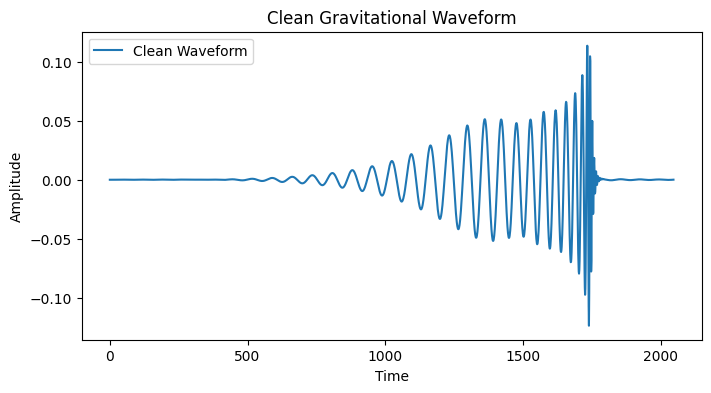

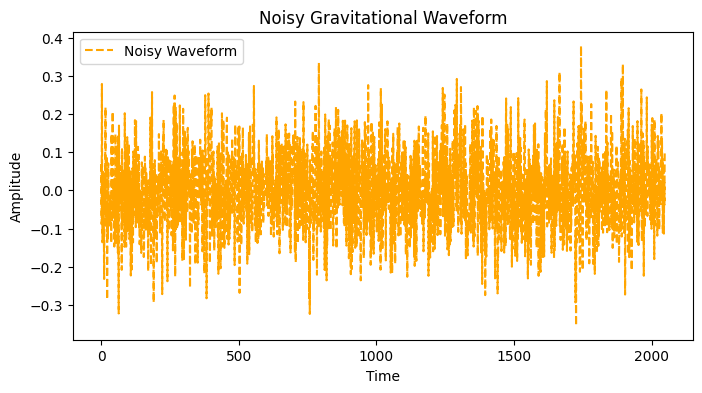

In [19]:
## clean GW
param = np.array([[30, 30]])
waves_template, _ = get_waves(1, spin=False, params=param) #no spin parameter



plt.figure(figsize=(8, 4))
plt.plot(waves_template[0], label='Clean Waveform')
plt.title('Clean Gravitational Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()




## noisy GW
z = np.random.normal(0, 1, size=waves_template.shape)
x = waves_template + 0.1 * z




plt.figure(figsize=(8, 4))
plt.plot(x[0], label='Noisy Waveform', linestyle='--', color='orange')
plt.title('Noisy Gravitational Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

## generate a set of GWs

In [23]:
n_waves = 1000  #number of waves to be generated



# Choose if you want spinning (True) or non-spinning (False) black holes
include_spin = False
waves, parameters = get_waves(n_waves, spin=include_spin, nonuniform=False)

100%|██████████| 1000/1000 [06:33<00:00,  2.54it/s]
